# Image Segmentation

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch08/8.1.Image_Segmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

In [1]:
semantic segmentation - segment semantic categories (all people instances belong to same category)
instance segmantation - segment individual instances/objects (https://arxiv.org/abs/1703.06870)

#Tutorial https://neptune.ai/blog/image-segmentation-in-2020
# Unet: https://www.tensorflow.org/tutorials/images/segmentation

FCN
Fully convolutional networks for semantic segmenta-tion.
https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf
# Converts the last fully con layer to a conv layer
# uses a deep jet technique to combine fuse local information to the coarse output

UNet
Uses FCN fully convolutional network
Encoder decoder

# Dialated FCN
# Converts all of CNNs to dialated CNNs
# Remove last two pooling layers leading to higher comp cplexity

FastFCN : https://arxiv.org/abs/1903.11816
# Backbone is the same as FCN
# Uses Joint Pooling (JPU) to create localized rep 
# Uses Encoding module to produce final output

# multi scale context module / PSPNet  https://arxiv.org/pdf/1612.01105.pdf

# bilinear interpolation
http://web.pdx.edu/~jduh/courses/geog493f09/Students/W6_Bilinear%20Interpolation.pdf
# weighted mean of n nearest points

use pretrained encoder
        
# losses 
# focal loss
# dice loss

https://github.com/qubvel/segmentation_models#models-and-backbones
https://tfhub.dev/s?module-type=image-segmentation
    
#metrics 
#pixel accuracy
# mean pixel IoU https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU

# What the chapter covers

# Understanding segmentation problem
# FCN architecture
# Training the FCN
# Fast FCN
#   Joint pyramid upsampling
#   Less complex final output prediction
# Describe losses
# Metric
# Training the new model

# survey
https://arxiv.org/pdf/2001.05566.pdf

SyntaxError: invalid syntax (<ipython-input-1-4739ff41fa47>, line 1)

In [1]:
import tensorflow as tf
#import tensorflow_hub as hub
import requests
print(tf.__version__)
import zipfile
import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow_addons as tfa
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import pickle
from tensorflow.keras.models import load_model, Model
from PIL import Image
from PIL.PngImagePlugin import PngImageFile
import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass
    
    
def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

2.2.1


In [2]:
%ls data

VOCtrainval_11-May-2012/  VOCtrainval_11-May-2012.tar


# Downloading and extracting the data

Cannot use https://www.tensorflow.org/datasets/catalog/voc, this is only for classification/detection
There're some segmentation datasets https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet, but not voc

In [3]:
# Downloading the data
#http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#data
import os
import requests
import tarfile

# Retrieve the data
if not os.path.exists(os.path.join('data','VOCtrainval_11-May-2012.tar')):
    url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')
    
    # Write to a file
    with open(os.path.join('data','VOCtrainval_11-May-2012.tar'), 'wb') as f:
        f.write(r.content)
else:
    print("The tar file already exists.")
    
if not os.path.exists(os.path.join('data', 'VOCtrainval_11-May-2012')):
    with tarfile.open(os.path.join('data','VOCtrainval_11-May-2012.tar'), 'r') as tar:
        tar.extractall('data')
else:
    print("The extracted data already exists")


The tar file already exists.
The extracted data already exists


## Load and visualize a single annotated image

JPEG
This image is of size: (375, 500, 3)
(375, 500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 499.5, 374.5, -0.5)

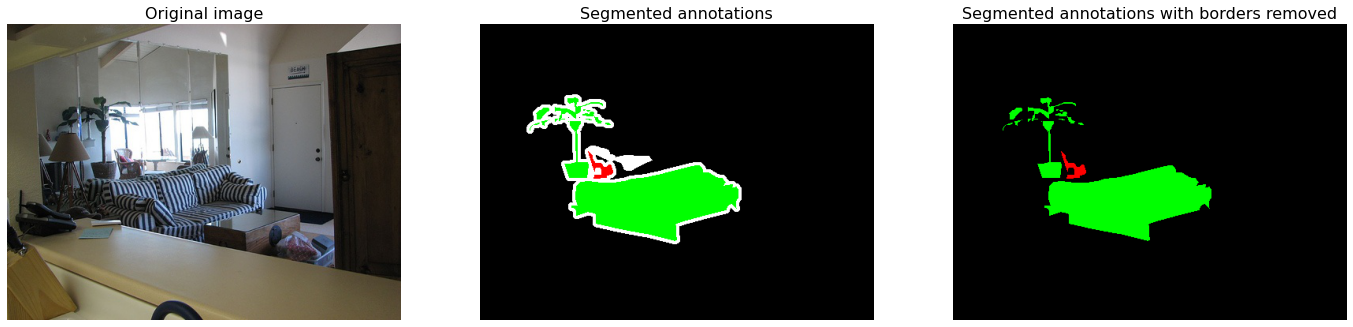

In [4]:


orig_image_path = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'JPEGImages', '2007_000661.jpg')
annot_image_path = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'SegmentationClass', '2007_000661.png')
                                
orig_image = Image.open(orig_image_path)
print(orig_image.format)
orig_image = np.array(orig_image)
print("This image is of size: {}".format(orig_image.shape))

annot_image = Image.open(annot_image_path)
print(np.array(annot_image).shape)
def rgb_image_from_pallette(image, pallette):
    """ This function restores the RGB values form a palletted PNG image """
    # Convert the pallet to a sequence of RGB values (n, 3) shape
    pallette = np.array(pallette).reshape(-1,3)
    if isinstance(image, PngImageFile):
        h, w = image.height, image.width
        # Squash height and width dimensions (makes slicing easier)
        image = np.array(image).reshape(-1)
    elif isinstance(image, np.ndarray):
        h, w = image.shape[0], image.shape[1]
        image = image.reshape(-1)
        
    rgb_image = np.zeros(shape=(image.shape[0],3))
    
    # For all locations where image value is not zero, 
    # we replace those locations in the RGB image with the corresponding values from the pallette
    rgb_image[(image != 0),:] = pallette[image[(image != 0)], :]
    rgb_image = rgb_image.reshape(h, w, 3)
    
    return rgb_image

def remove_white_pixels(image, pallette):
    """ White pixels are either border or unknown objects, both of which we're not interested in """
    # 255 - void category, used for border regions (5px) and to mask difficult objects
    img_arr = np.array(image)
    row_idx, col_idx = np.nonzero((img_arr==255))
    
    rgb_image = rgb_image_from_pallette(image, pallette)    
    rgb_image[row_idx, col_idx, :] = 0
    return rgb_image

pallette = annot_image.getpalette()
annot_rgb_image = rgb_image_from_pallette(annot_image, pallette)
annot_no_border_image = remove_white_pixels(annot_image, pallette)

plt.subplots(1,3, figsize=(24,8))
plt.subplot(1,3,1)
plt.imshow(orig_image)
plt.title("Original image", fontsize=16)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(annot_rgb_image)
plt.title("Segmented annotations", fontsize=16)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(annot_no_border_image)
plt.title("Segmented annotations with borders removed", fontsize=16)
plt.axis('off')

In [5]:
# Classes 1 - 21 ( 0 - Background)
VOC_CLASSES = ['Background', 'Aeroplane', 'Bicycle', 'Bird', 'Boat',
               'Bottle', 'bus', 'Car', 'Cat', 'Chair', 'Cow',
               'Dining table', 'Dog', 'Horse', 'Motorbike', 'Person',
               'Potted plant', 'Sheep', 'Sofa', 'Train', 'TV/Monitor']


## Input data pipeline

Try setting up the pipeline without resizing images

```
InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [375,500,3] and element 1 had shape [333,500,3]. [Op:IteratorGetNext]
```

Found 122 training batches
Found 61 validation batches
DatasetSpec((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)), TensorShape([]))
Input: (12, 256, 256, 3), Target: (12, 256, 256)
tf.Tensor(255.0, shape=(), dtype=float32)
Input: (12, 256, 256, 3), Target: (12, 256, 256)
tf.Tensor(255.0, shape=(), dtype=float32)
Input: (12, 256, 256, 3), Target: (12, 256, 256)
Input: (12, 256, 256, 3), Target: (12, 256, 256)


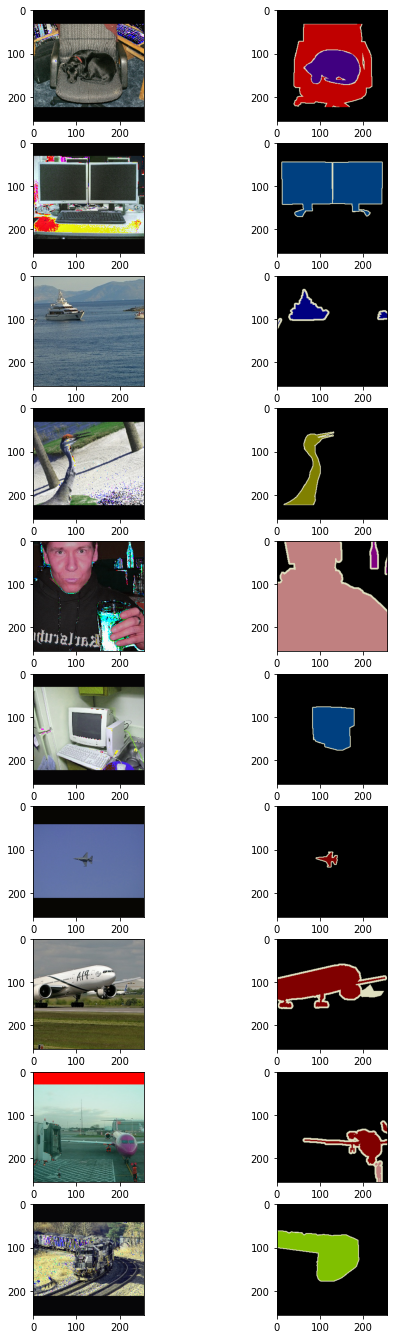

In [87]:
import glob
from functools import partial
import random

# run a verification to make sure orig dir and seg dir only contains images with same aname

def get_subset_filenames(orig_dir, seg_dir, subset_dir, subset):
    
    if subset.startswith('train'):
        ser = pd.read_csv(os.path.join(subset_dir, "train.txt"), index_col=None, header=None, squeeze=True).tolist()
    elif subset.startswith('val') or subset.startswith('test'):
        random.seed(random_seed)
        ser = pd.read_csv(os.path.join(subset_dir, "val.txt"), index_col=None, header=None, squeeze=True).tolist()
        random.shuffle(ser)
        if subset.startswith('val'):
            ser = ser[:len(ser)//2]
        else:
            ser = ser[len(ser)//2:]        
    else:
        raise NotImplementedError("Subset={} is not recognized".format(subset))
        
    orig_filenames = [os.path.join(orig_dir,f+'.jpg') for f in ser]
    seg_filenames = [os.path.join(seg_dir, f+'.png') for f in ser]
    
    for o, s in zip(orig_filenames, seg_filenames):
        yield o, s
    
    
batch_size = 12
epochs = 50

orig_dir = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'JPEGImages')
seg_dir = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'SegmentationClass')
subset_dir = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'ImageSets', "Segmentation")

def get_steps_per_epoch(n_data, batch_size):
    if n_data % batch_size == 0:
        return n_data//batch_size
    else:
        return (n_data//batch_size)+1
    
    
n_train = get_steps_per_epoch(
    len(pd.read_csv(os.path.join(subset_dir, "train.txt"), index_col=None, header=None, squeeze=True).tolist()),
    batch_size
)
n_valid = get_steps_per_epoch(
    len(pd.read_csv(os.path.join(subset_dir, "val.txt"), index_col=None, header=None, squeeze=True).tolist())//2,
    batch_size
)

print("Found {} training batches".format(n_train))
print("Found {} validation batches".format(n_valid))

partial_subset_fn = partial(get_subset_filenames, orig_dir=orig_dir, seg_dir=seg_dir, subset_dir=subset_dir)
train_subset_fn = partial(partial_subset_fn, subset='train')
val_subset_fn = partial(partial_subset_fn, subset='val')
test_subset_fn = partial(partial_subset_fn, subset='test')

def get_subset_tf_dataset(gen_func, batch_size, epochs, augmentation=False, shuffle=False):
    filename_ds = tf.data.Dataset.from_generator(
        gen_func, output_types=(tf.string, tf.string)
    )

    def load_image_func(image):
        img =  np.array(Image.open(image))        
        return img


    image_ds = filename_ds.map(lambda x,y: (
        tf.image.decode_jpeg(tf.io.read_file(x)), 
        tf.numpy_function(load_image_func, [y], [tf.uint8])
    ))
        
    
    image_ds = image_ds.map(lambda x, y: (tf.cast(x, 'float32')/255.0, y))
    
    def randomly_crop_or_resize(x,y):
        rand = tf.random.uniform([], 0.0,1.0)
        
        def rand_crop(x, y):
            
            x = tf.image.resize_with_pad(x, 372, 500, method='nearest')
            y = tf.cast(tf.image.resize_with_pad(tf.transpose(y,[1,2,0]), 372, 500, method='nearest'),'float32')          
            
            offset_h = tf.random.uniform([], 0, x.shape[0]-256, dtype='int32')
            offset_w = tf.random.uniform([], 0, x.shape[1]-256, dtype='int32')
            x = tf.image.crop_to_bounding_box(x, offset_h, offset_w, 256,256)
            y = tf.image.crop_to_bounding_box(y, offset_h, offset_w, 256,256)
            
            return x, y
        
        def resize(x, y):
            x = tf.image.resize_with_pad(x, 256, 256, method='nearest')
            y = tf.cast(tf.image.resize_with_pad(tf.transpose(y,[1,2,0]), 256, 256, method='nearest'),'float32')          
            
            return x, y
        
        x, y = tf.cond(
            rand < 0.5,
            lambda: rand_crop(x, y),
            lambda: resize(x, y)
        )
        
        return x, y
        
    # This is an important step. Basically if you want to batch data, they should have the same shape
    if augmentation:
        image_ds = image_ds.map(lambda x,y: randomly_crop_or_resize(x,y))
    else:
        image_ds = image_ds.map(lambda x,y: (
            tf.image.resize_with_pad(x, 256, 256, method='nearest'), 
            tf.cast(tf.image.resize_with_pad(tf.transpose(y,[1,2,0]), 256, 256, method='nearest'),'float32')
        ))
    
    def fix_shape(x, y):
        x.set_shape((256, 256, 3))
        y.set_shape((256, 256, 1))
        return x, y
    
    image_ds = image_ds.map(lambda x,y: fix_shape(x,y))
    
    
    def randomly_flip_horizontal(x, y):
        
        rand = tf.random.uniform([], 0.0,1.0)
        
        def flip(x, y):
            return tf.image.flip_left_right(x), tf.image.flip_left_right(y)
                
        x, y = tf.cond(rand < 0.5, lambda: flip(x, y), lambda: (x, y))        
        
        return x, y
    
    def randomly_translate(x, y):
        
        tx, ty = tf.random.uniform([],-50, 50),  tf.random.uniform([], -50, 50)
        
        x, y = tfa.image.translate(x, [tx, ty]), tfa.image.translate(y, [tx, ty])
        return x, y
    
    if augmentation:    
        
        image_ds = image_ds.map(lambda x, y: randomly_flip_horizontal(x,y))
        image_ds = image_ds.map(lambda x, y: (tf.image.random_hue(x, 0.1), y))
        image_ds = image_ds.map(lambda x, y: (tf.image.random_brightness(x, 0.1), y))
        image_ds = image_ds.map(lambda x, y: (tf.image.random_contrast(x, 0.8, 1.2), y))
    
    # Convert to class 
    if shuffle:
        image_ds = image_ds.shuffle(buffer_size=batch_size*5)
    
    image_ds = image_ds.batch(batch_size).repeat(epochs)
    
    image_ds = image_ds.map(lambda x, y: (x, tf.squeeze(y)))
    
    return image_ds


tr_image_ds = get_subset_tf_dataset(train_subset_fn, batch_size, epochs, shuffle=True)
val_image_ds = get_subset_tf_dataset(val_subset_fn, batch_size, epochs, shuffle=False)

print(tf.data.DatasetSpec.from_value(tr_image_ds))

for i, j in tr_image_ds.take(2):
    print("Input: {}, Target: {}".format(i.shape, j.shape))
    print(tf.reduce_max(j))
for i, j in val_image_ds.take(2):
    print("Input: {}, Target: {}".format(i.shape, j.shape))


tr_image_ds = get_subset_tf_dataset(train_subset_fn, 1, 1, augmentation=True, shuffle=True)
n=10
plt.subplots(n, 2, figsize=(8,24))
i=0
for img, y_true in tr_image_ds.take(n):
        
    y_true = y_true.numpy().astype('int')
    
    y_rgb_true = rgb_image_from_pallette(y_true, pallette)
    
    plt.subplot(n,2,i*2+1)
    plt.imshow((img[0,:, :, :].numpy()*255.0).astype('uint8'))    
    plt.subplot(n,2, i*2+2)
    plt.imshow(y_rgb_true.astype('uint8'))
    
    i += 1
    
tr_image_ds = get_subset_tf_dataset(train_subset_fn, batch_size, epochs, augmentation=True, shuffle=True)
val_image_ds = get_subset_tf_dataset(val_subset_fn, batch_size, epochs, shuffle=False)
test_image_ds = get_subset_tf_dataset(test_subset_fn, 1, 1, shuffle=False)

## Why original u-net doesn't work

if you have images / targets with original sizes proposed for original unet paper, the model won't learn. possible reasons,

* inputs to u-net are relatively large, requiring more parameters to learn from images

In [88]:


def downsample_layer(inp, filters, downsample=True, with_bn=True):
    
    if downsample:
        inp = layers.MaxPooling2D((2,2), strides=(2,2))(inp)
        
    conv1_out = layers.Conv2D(filters, (3,3), activation='relu', padding='same')(inp)
    if with_bn:
        conv1_out = layers.BatchNormalization()(conv1_out)    
    
    conv2_out = layers.Conv2D(filters, (3,3), activation='relu', padding='same')(conv1_out)
    if with_bn:
        conv2_out = layers.BatchNormalization()(conv2_out)
    out = conv2_out
    
    return out

def upsample_conv(inp, copy_and_crop, filters, with_bn=False):
    
    conv1_out = layers.Conv2DTranspose(filters, (2,2), (2,2), activation='relu')(inp)
    crop_side = int((copy_and_crop.shape[1]-conv1_out.shape[1])/2)

    if crop_side > 0:
        cropped_copy = layers.Cropping2D(crop_side)(copy_and_crop)
    else:
        cropped_copy = copy_and_crop
        
    concat_out = layers.Concatenate(axis=-1)([conv1_out, cropped_copy])
    
    conv2_out = layers.Conv2D(filters, (3,3), activation='relu', padding='same')(concat_out)
    if with_bn:
        conv2_out = layers.BatchNormalization()(conv2_out)
    
    out = layers.Conv2D(filters, (3,3), activation='relu', padding='same')(conv2_out)
    if with_bn:
        out = layers.BatchNormalization()(out)
    
    
    return out

In [89]:
num_classes = 21

def get_label_weights(y_true, y_pred):
    
    weights = tf.reduce_sum(tf.one_hot(y_true, num_classes), axis=[1,2]) # [b, classes]
    
    tot = tf.reduce_sum(weights, axis=-1, keepdims=True) 
    weights = (tot - weights) / tot # [b, classes]
    
    y_true = tf.reshape(y_true, [-1, y_pred.shape[1]*y_pred.shape[2]]) #[b, -1]
        
    # weights -> [b, classes] / y_true -> [b, xx]
    y_weights = tf.gather(weights, y_true, batch_dims=1)     
    y_weights = tf.reshape(y_weights, [-1])
    
    return y_weights


def dice_loss(y_true, y_pred, from_logits=True):
    smooth = 1.
    
    y_true = tf.cast(y_true, 'int32')
    y_true.set_shape([None, y_pred.shape[1], y_pred.shape[2]])
    
    y_weights = tf.reshape(get_label_weights(y_true, y_pred), [-1, 1])
    
    if from_logits:        
        y_pred = tf.nn.softmax(y_pred)
    
    y_true_unwrap = tf.reshape(y_true, [-1])
    y_true_unwrap = tf.cast(tf.one_hot(tf.cast(y_true_unwrap, 'int32'), num_classes), 'float32')
    y_pred_unwrap = tf.reshape(y_pred, [-1, num_classes])
        
    # no noeed for valid mask, labels outside the size of num_classess are ignored
    intersection = tf.reduce_sum(y_true_unwrap * y_pred_unwrap * y_weights)
    union = tf.reduce_sum((y_true_unwrap + y_pred_unwrap) * y_weights)
    score = (2. * intersection + smooth) / ( union + smooth)
    
    loss = 1 - score
    
    return loss


def mean_iou(y_true, y_pred, from_logits=True, ignore_background=True):
        
    smooth = 1.   
    
    if from_logits:        
        y_pred = tf.nn.softmax(y_pred)
    
    y_true.set_shape([None, y_pred.shape[1], y_pred.shape[2]])
    
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(tf.argmax(y_pred, axis=-1),[-1])
    if not ignore_background:
        valid_mask = tf.reshape((y_true <= num_classes - 1), [-1])
    else:
        valid_mask = tf.reshape(tf.logical_and((y_true > 0),(y_true <= num_classes - 1)), [-1])
    
    y_true = tf.boolean_mask(y_true, valid_mask)
    y_pred = tf.boolean_mask(y_pred, valid_mask)
        
    conf_matrix = tf.cast(tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes), 'float32')
    true_pos = tf.linalg.diag_part(conf_matrix)
    
    
    mean_iou = tf.reduce_mean(
        (true_pos+smooth)/(tf.reduce_sum(conf_matrix, axis=0)+tf.reduce_sum(conf_matrix, axis=1)-true_pos+smooth)
    )
    
    return mean_iou


def mean_accuracy(y_true, y_pred, from_logits=True):
    
    if from_logits:        
        y_pred = tf.nn.softmax(y_pred)
    
    y_true.set_shape([None, y_pred.shape[1], y_pred.shape[2]])
    
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(tf.argmax(y_pred, axis=-1),[-1])
    if not ignore_background:
        valid_mask = tf.reshape((y_true <= num_classes - 1), [-1])
    else:
        valid_mask = tf.reshape(tf.logical_and((y_true > 0),(y_true <= num_classes - 1)), [-1])
    
    y_true = tf.boolean_mask(y_true, valid_mask)
    y_pred = tf.boolean_mask(y_pred, valid_mask)
    
    # sum on axis=0 > prediction counts 
    # sum on axis=1 > actual counts
    conf_matrix = tf.cast(tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes), 'float32')
    true_pos = tf.linalg.diag_part(conf_matrix)
    
    mean_accuracy = tf.reduce_mean(
        (true_pos + smooth)/(tf.reduce_sum(conf_matrix, axis=1) + smooth)
    )
    
def ce(y_true, y_pred, from_logits = True):
    
    valid_mask = tf.cast(tf.reshape((y_true <= num_classes - 1), [-1,1]), 'int32')
    
    y_pred_unwrap = tf.reshape(y_pred, [-1, num_classes])            
    y_true_unwrap = tf.reshape(y_true, [-1])
    
    return tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            tf.cast(y_true_unwrap, 'int32')*tf.squeeze(valid_mask), 
            y_pred_unwrap * tf.cast(valid_mask, 'float32'))
    )


def ce_weighted(y_true, y_pred, from_logits = True):
        
    valid_mask = tf.cast(tf.reshape((y_true <= num_classes - 1), [-1,1]), 'int32')
    y_true = tf.cast(y_true, 'int32')
    y_true.set_shape([None, y_pred.shape[1], y_pred.shape[2]])
    
    
    y_weights = get_label_weights(y_true, y_pred)
    y_pred_unwrap = tf.reshape(y_pred, [-1, num_classes])            
    y_true_unwrap = tf.reshape(y_true, [-1]) 
    
    return tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            y_true_unwrap*tf.squeeze(valid_mask), 
            y_pred_unwrap * tf.cast(valid_mask, 'float32')) * y_weights
    )

def ce_dice_loss(y_true, y_pred, from_logits=True):
    loss = ce_weighted(tf.cast(y_true, 'int32'), y_pred) + dice_loss(y_true, y_pred)    
    return loss


Using pretrained encoder

In [90]:

K.clear_session()



def decoder(inp, encoder):
    up_1 = upsample_conv(inp, encoder.get_layer("conv4_block6_out").output, 1024)  # 16x16

    up_2 = upsample_conv(up_1, encoder.get_layer("conv3_block4_out").output, 512) # 32x32

    up_3 = upsample_conv(up_2, encoder.get_layer("conv2_block3_out").output, 256) # 64x64

    up_4 = upsample_conv(up_3, encoder.get_layer("conv1_relu").output, 128) # 128 x 128
    
    up_5 = upsample_conv(up_4, encoder.get_layer("conv1_pad").output, 64) # 256 x 256
    
    return up_5

def unet_pretrained_encoder():
    
    inp = layers.Input(shape=(256, 256, 3))
    encoder = tf.keras.applications.ResNet50(
        include_top=False, input_tensor=inp,pooling=None
    )
    
    
    decoder_inp = encoder(inp) # 8x8
    decoder_out = decoder(decoder_inp, encoder)
    
    final_out = layers.Conv2D(num_classes, (1,1))(decoder_out)
    #final_out = layers.Reshape([21,])(final_out)
    model = models.Model(inp, final_out)
    return model


unet = unet_pretrained_encoder()
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
#mean_iou = tf.keras.metrics.MeanIoU(21)
unet.compile(loss=ce_dice_loss, optimizer=optimizer, metrics=[mean_iou])
unet.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [91]:
if not os.path.exists('eval'):
    os.mkdir('eval')
    
# Logging the performance metrics to a CSV file
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join('eval','1_pretrained_unet.log'))

monitor_metric = 'val_loss'
mode = 'min' if 'loss' in monitor_metric else 'max'
print("Using metric={} and mode={} for EarlyStopping".format(monitor_metric, mode))
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor_metric, factor=0.1, patience=3, mode=mode, min_lr=1e-8
)
# EarlyStopping itself increases the memory requirement
# restore_best_weights will increase the memory req for large models
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=monitor_metric, patience=6, mode=mode, restore_best_weights=False
)

unet.fit(
    tr_image_ds, steps_per_epoch=n_train,
    validation_data=val_image_ds, validation_steps=n_valid, 
    epochs=epochs, callbacks=[lr_callback, csv_logger])
#model.fit(x, y)

Using metric=val_loss and mode=min for EarlyStopping
Epoch 1/50
122/122 [==============================] - 78s 637ms/step - loss: 1.2385 - mean_iou: 0.4185 - val_loss: 1.9058 - val_mean_iou: 0.4180 - lr: 1.0000e-04
Epoch 2/50
122/122 [==============================] - 76s 620ms/step - loss: 1.0754 - mean_iou: 0.4410 - val_loss: 1.1886 - val_mean_iou: 0.4228 - lr: 1.0000e-04
Epoch 3/50
122/122 [==============================] - 76s 624ms/step - loss: 0.9731 - mean_iou: 0.4331 - val_loss: 0.9675 - val_mean_iou: 0.3892 - lr: 1.0000e-04
Epoch 4/50
122/122 [==============================] - 77s 627ms/step - loss: 0.9331 - mean_iou: 0.3692 - val_loss: 0.8589 - val_mean_iou: 0.3632 - lr: 1.0000e-04
Epoch 5/50
122/122 [==============================] - 76s 626ms/step - loss: 0.8689 - mean_iou: 0.3074 - val_loss: 0.8205 - val_mean_iou: 0.3088 - lr: 1.0000e-04
Epoch 6/50
122/122 [==============================] - 77s 627ms/step - loss: 0.8378 - mean_iou: 0.2713 - val_loss: 0.8139 - val_mean_iou:

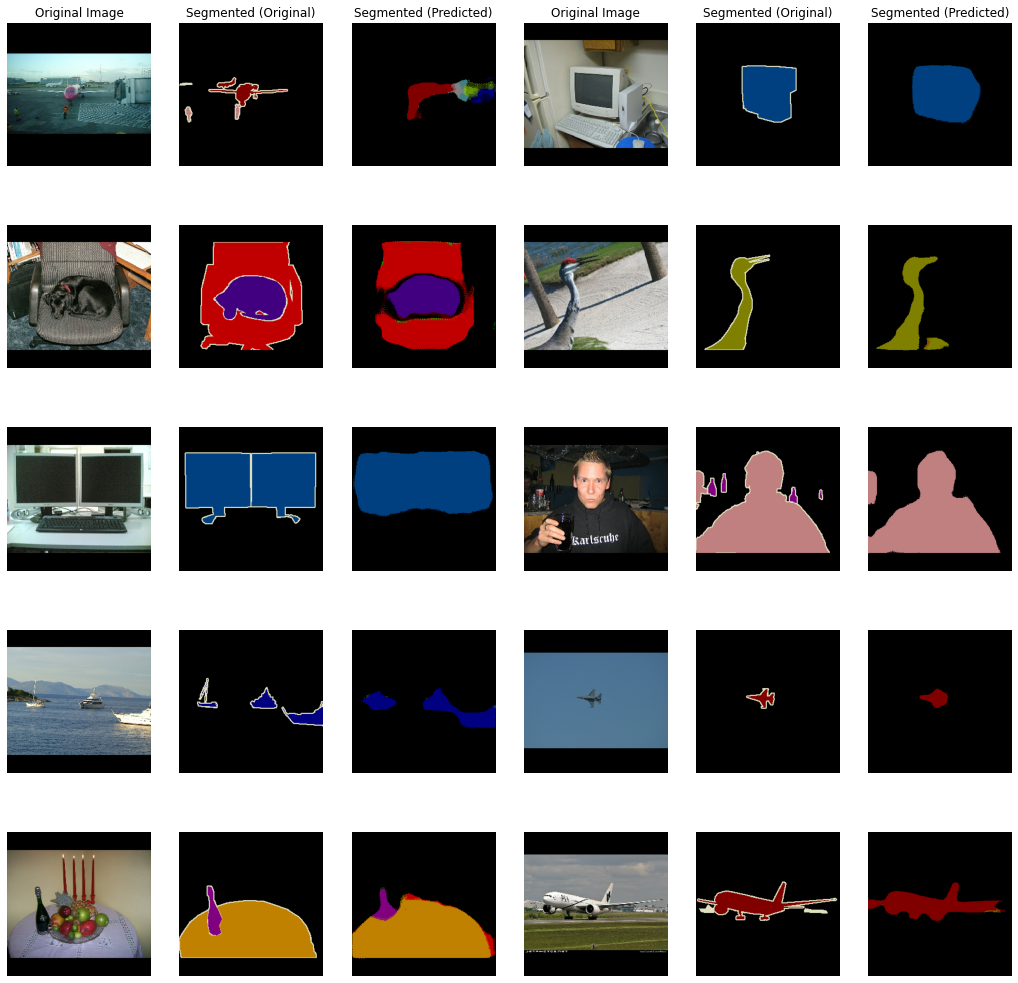

In [110]:
train_image_ds = get_subset_tf_dataset(train_subset_fn, 1, 1, augmentation=False, shuffle=False)
n = 10

def generate_results_plot(image_ds, n):
    
    plt.subplots(n//2, 3*2, figsize=(18,18))

    i=0

    for img, y_true in image_ds.take(n):

        img_pred = unet.predict(img)

        y_pred = np.argmax(img_pred[0,:,:,:], axis=-1)

        y_true = y_true.numpy().astype('int')

        y_rgb_pred = rgb_image_from_pallette(y_pred, pallette)
        y_rgb_true = rgb_image_from_pallette(y_true, pallette)

        if i%2==0:
            row = i
            col_off=0
        else:
            row = i-1
            col_off=3
        
        plt.subplot(n//2,6,row*3+col_off+1)
        plt.imshow((img[0,:, :, :].numpy()*255.0).astype('uint8'))
        plt.axis('off')
        if row==0:
            plt.title('Original Image')

        plt.subplot(n//2,6, row*3+col_off+2)    
        plt.imshow(y_rgb_true.astype('uint8'))
        plt.axis('off')
        if row==0:
            plt.title('Segmented (Original)')

        plt.subplot(n//2,6, row*3+col_off+3)
        plt.imshow(y_rgb_pred.astype('uint8'))    
        plt.axis('off')
        if row==0:
            plt.title('Segmented (Predicted)')
        i += 1
    
generate_results_plot(train_image_ds, n)   
    
    

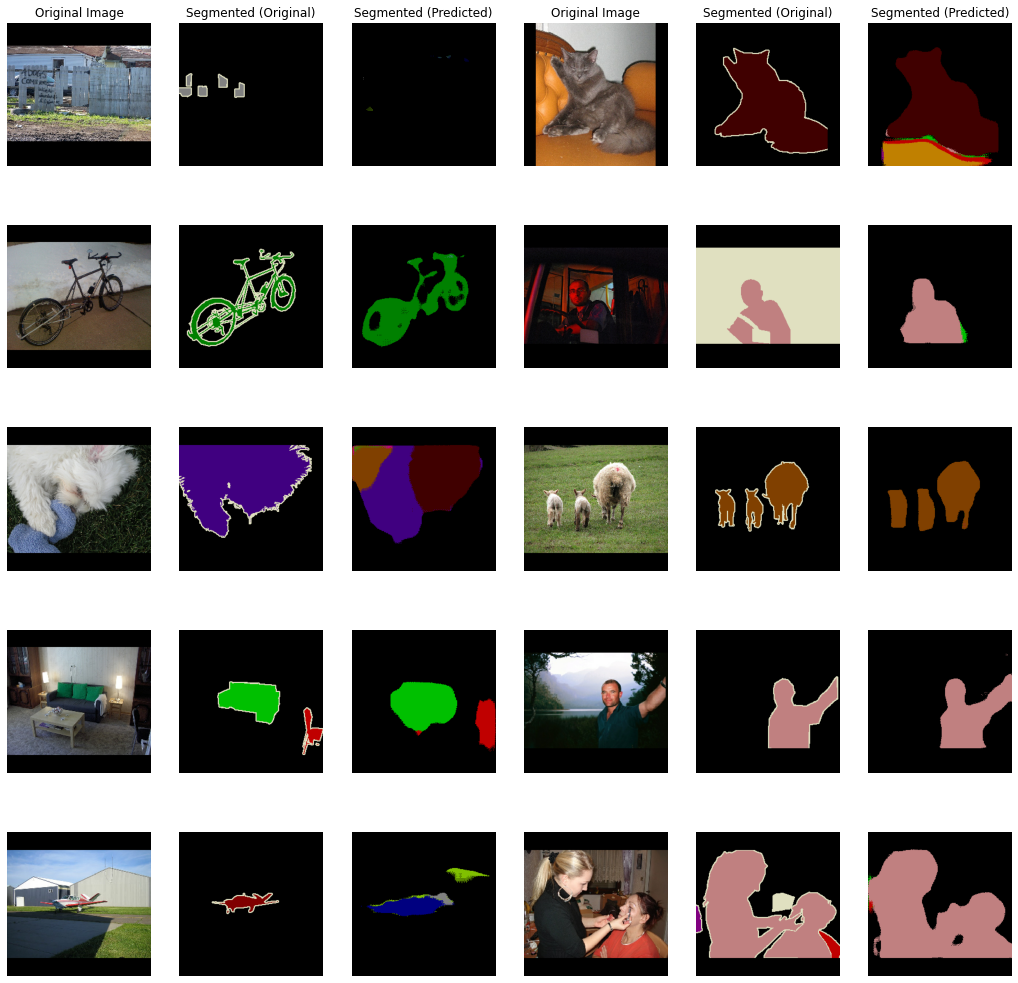

In [111]:
test_image_ds = get_subset_tf_dataset(test_subset_fn, 1, 1, shuffle=False)
n=10
generate_results_plot(test_image_ds, n)

In [51]:


K.clear_session()

num_classes = 21




with_bn = True

inp = layers.Input(shape=(256, 256, 3))
scale_factor = 1

down_1 = downsample_layer(inp, 64/scale_factor, downsample=False, with_bn = with_bn) # 256

down_2 = downsample_layer(down_1, 128/scale_factor, with_bn = with_bn) # 128
 
down_3 = downsample_layer(down_2, 256/scale_factor, with_bn = with_bn) # 64


down_4 = downsample_layer(down_3, 512/scale_factor, with_bn = with_bn) # 32

down_5 = downsample_layer(down_4, 1024/scale_factor, with_bn = with_bn) #16



up_1 = upsample_conv(down_5, down_4, 512/scale_factor)  #

up_2 = upsample_conv(up_1, down_3, 256/scale_factor)

up_3 = upsample_conv(up_2, down_2, 128/scale_factor)

up_4 = upsample_conv(up_3, down_1, 64/scale_factor)

final_out = layers.Conv2D(num_classes, (1,1))(up_4)
#final_out = layers.Reshape([21,])(final_out)
model = models.Model(inp, final_out)



from functools import partial
#loss = tfa.losses.SigmoidFocalCrossEntropy(from_logits = False)
#loss = ce_dice_loss
#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = ce_weighted

#optimizer = tf.keras.optimizers.SGD(0.1, momentum=0.9)
mean_iou = tf.keras.metrics.MeanIoU(21)
model.compile(loss=loss, optimizer='adam')#, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [52]:
def scheduler(epoch, lr):
  if epoch==0:
    return lr
  else:
    return lr * 0.9


callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5
)


model.fit(
    tr_image_ds, steps_per_epoch=n_train,
    validation_data=val_image_ds, validation_steps=n_valid, 
    epochs=epochs, callbacks=[callback])
#model.fit(x, y)

Epoch 1/50
 20/122 [===>..........................] - ETA: 40s - loss: 0.5779

KeyboardInterrupt: 

In [9]:
a = tf.convert_to_tensor([[2,2,1],[0,0,1]])
b = tf.convert_to_tensor([[0.5, 0.6, 0.1], [0.5, 0.2, 0.3]])

print(a.shape)
print(b.shape)
c = tf.gather(b, a, batch_dims=1)
print(c)
print(c.shape)

a = tf.convert_to_tensor([2,3,1,255])
b = tf.one_hot(a, 4)
print(b)

(2, 3)
(2, 3)
tf.Tensor(
[[0.1 0.1 0.6]
 [0.5 0.5 0.2]], shape=(2, 3), dtype=float32)
(2, 3)
tf.Tensor(
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float32)


In [ ]:
model.evaluate(test_image_ds)